In [1]:
import numpy as np
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from sklearn.preprocessing import StandardScaler
import pandas as pd

from utils import *

In [2]:
device = torch.device('cuda:0')

In [3]:
class args:
    result_dir = '../results/cicidsv3.0'
    batch_size = 256
    dataset = "2018"
    exp=1
    epochs = 30

In [4]:
if args.dataset =="2017":
    from main_utils import exp_label_2017
    lab_cluster, lab_dic, lab_name, ooc_cols = exp_label_2017(args.exp)   
    from main_utils import lab_2017 as lab_name_tot
else:
    from main_utils import exp_label_2018
    lab_cluster, lab_dic, lab_name, ooc_cols = exp_label_2018(args.exp)
    from main_utils import lab_2018 as lab_name_tot 

{'Brute Force -Web': 0, 'Brute Force -XSS': 0, 'DoS attacks-Hulk': 1, 'DoS attacks-GoldenEye': 1, 'DoS attacks-Slowloris': 1, 'DDoS attacks-LOIC-HTTP': 2, 'DDOS attack-HOIC': 2, 'Bot': 3, 'Infilteration': 4, 'SSH-Bruteforce': 5}


In [12]:
lab_name

['Web_Attack', 'DoS_attacks', 'DDoS_attacks', 'Bot', 'PortScan', 'Bruteforce']

In [5]:
train_df = pd.read_parquet(os.path.join(args.result_dir,"cicids%s_traindf.parquet"%args.dataset))
test_df = pd.read_parquet(os.path.join(args.result_dir,"cicids%s_testdf.parquet"%args.dataset))

In [6]:
cicids_bn = load_cicids_binary_data(args.dataset, lab_cluster, lab_name, args.result_dir,
                                       return_scaler=True, ooc_cols=None)
cicids_m = load_cicids_mult_data(args.dataset, lab_dic, lab_name, args.result_dir,
                                       return_scaler=True, ooc_cols=None)

drop Benign
drop SQL Injection
drop DoS attacks-SlowHTTPTest
drop FTP-BruteForce
original instances:  5971201
drop intances:  5310613
after drop:  660588
drop Benign
drop SQL Injection
drop DoS attacks-SlowHTTPTest
drop FTP-BruteForce
original instances:  1492801
drop intances:  1327437
after drop:  165364


In [7]:
bn_save_model, mul_save_model = load_model_path(args.dataset, lab_name, args.epochs, 
                                                None, True, True)

In [8]:
mul_save_model

'cicids2018_epochs_30_LS__OE_mul_clf.pth'

In [9]:
n_features = cicids_m[0].shape[1]
n_class = len(np.unique(cicids_m[1]))
n_hidden = 32

clf_bn = BinaryNN(cicids_bn[0].shape[1])
clf_bn.load_state_dict(torch.load(os.path.join(args.result_dir, bn_save_model),map_location='cpu'))
clf_mul = MultNN(n_features, n_hidden, n_class)
clf_mul.load_state_dict(torch.load(os.path.join(args.result_dir, mul_save_model),map_location='cpu'))

<All keys matched successfully>

In [14]:
from main_utils import make_splitted_dataloader
te_bndls, te_muldls = make_splitted_dataloader(test_df, 'Label', cicids_bn[4],cicids_m[4], lab_dic, device, 128)

In [16]:
hclf = HClassifier(clf_bn, clf_mul, device, thres_bn = 0.2, thres_mul=0.55, ooc_class = n_class+1)
pred_res = {}
count_name = ['Benign']+lab_name+['Unseen']
print(count_name)
for lnt in lab_name_tot:
    pred_res[lnt] = hclf.predict(te_bndls[lnt], te_muldls[lnt])   
    print("true type: ", lnt, "(%s)"%len(pred_res[lnt]))
    with np.printoptions(precision=3, suppress=True):
        print(np.bincount(pred_res[lnt].numpy()+1))
        print(np.bincount(pred_res[lnt].numpy()+1)/len(pred_res[lnt]))

['Benign', 'Web_Attack', 'DoS_attacks', 'DDoS_attacks', 'Bot', 'PortScan', 'Bruteforce', 'Unseen']
true type:  Benign (1327396)
[1146839       4     178      33     169    6283     140       0       0
       0       0  173750]
[0.864 0.    0.    0.    0.    0.005 0.    0.    0.    0.    0.    0.131]
true type:  Brute Force -Web (53)
[24 27  0  0  0  1  0  0  0  0  0  1]
[0.453 0.509 0.    0.    0.    0.019 0.    0.    0.    0.    0.    0.019]
true type:  Brute Force -XSS (24)
[ 1 22  0  0  0  1]
[0.042 0.917 0.    0.    0.    0.042]
true type:  SQL Injection (13)
[6 0 0 1 0 3 0 0 0 0 0 3]
[0.462 0.    0.    0.077 0.    0.231 0.    0.    0.    0.    0.    0.231]
true type:  DoS attacks-Hulk (5032)
[   0    0 5032]
[0. 0. 1.]
true type:  DoS attacks-GoldenEye (5570)
[   1    0 5567    0    0    0    0    0    0    0    0    2]
[0.    0.    0.999 0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
true type:  DoS attacks-Slowloris (1536)
[   7    0 1521    0    0    0    0    0    0   

In [19]:
unseen_class = ['Web Attack \x96 Sql Injection','Heartbleed', 'Infiltration']

In [13]:
import matplotlib.pyplot as plt
import numpy as np

print(np.bincount(pred_res['Benign'].numpy()+1)/len(pred_res['Benign']))
print(np.bincount(pred_res['Benign'].numpy()+1)/len(pred_res['Benign']))

array([177803,     14,    439,      6,    142,   1887,     81,      0,
            0,      0,      0,   7288])

In [11]:
print(te_bndls['Benign'].dataset.tensors[0].shape, te_muldls['Benign'].dataset.tensors[0].shape)

torch.Size([187660, 67]) torch.Size([187660, 67])


In [12]:
print(te_bndls['DoS Slowhttptest'].dataset.tensors[0].shape, te_muldls['DoS Slowhttptest'].dataset.tensors[0].shape)

torch.Size([410, 67]) torch.Size([410, 67])


In [13]:
hclf = HClassifier(clf_bn, clf_mul, device)

In [37]:
tot_pred = get_hier_prediction(clf_bn, clf_mul, te_bndls['Benign'], te_muldls['Benign'], device, thres_mul=0.4)

tensor(179693)


In [38]:
sum(tot_pred == -1.0)/len(tot_pred)

tensor(0.9475)

In [30]:
aa = torch.softmax(get_prediction(clf_mul, te_muldls['Benign'], device), dim=1)

In [34]:
cc,bb = torch.max(aa, dim=1)

In [35]:
cc

tensor([0.2167, 0.2146, 0.2125,  ..., 0.1787, 0.1839, 0.1850])

In [22]:
def dataloader_with_scaler(datadf, scaler, batch_size, shuffle):
    scaled_df = scaler.transform(datadf)
    label = np.zeros(datadf.shape[0])
    data_loader = make_dataloader(scaled_df, label, batch_size = batch_size, shuffle=shuffle)
    return data_loader

preds = {}

preds['trbn'] = []
preds['tebn'] = []
preds['trm'] = []
preds['tem'] = []

for lnt in lab_name_tot:
    
    print("result for ", lnt)
    xtr = train_df[train_df['Label']==lnt].loc[:,train_df.columns!='Label']
    xte = test_df[test_df['Label']==lnt].loc[:,test_df.columns!='Label']
    trbnl = dataloader_with_scaler(xtr, cicids_bn[4], args.batch_size, False)
    tebnl = dataloader_with_scaler(xte, cicids_bn[4], args.batch_size, False)
    preds['trbn'].append(get_prediction(clf_bn, trbnl, device))
    preds['tebn'].append(get_prediction(clf_bn, tebnl, device))
    
    trml = dataloader_with_scaler(xtr, cicids_m[4], args.batch_size, False)
    teml = dataloader_with_scaler(xte, cicids_m[4], args.batch_size, False)
    preds['trm'].append(torch.softmax(get_prediction(clf_mul, trml, device),dim=1))
    preds['tem'].append(torch.softmax(get_prediction(clf_mul, teml, device),dim=1))
    
    

result for  Benign
result for  Web Attack  Brute Force
result for  Web Attack  XSS
result for  Web Attack  Sql Injection
result for  DoS Hulk
result for  DoS GoldenEye
result for  DoS slowloris
result for  DoS Slowhttptest
result for  DDoS
result for  Bot
result for  PortScan
result for  FTP-Patator
result for  SSH-Patator
result for  Heartbleed
result for  Infiltration


Benign


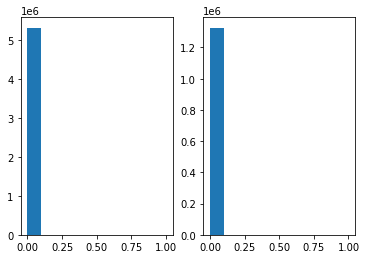

Benign


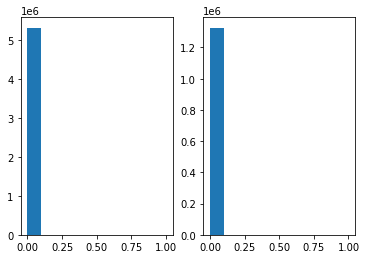

Brute Force -Web


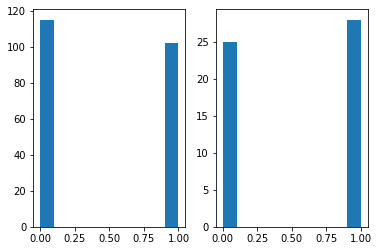

Brute Force -XSS


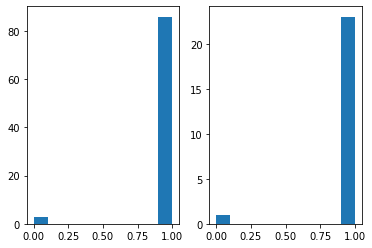

SQL Injection


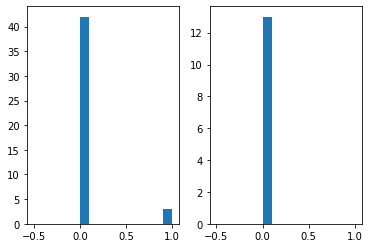

DoS attacks-Hulk


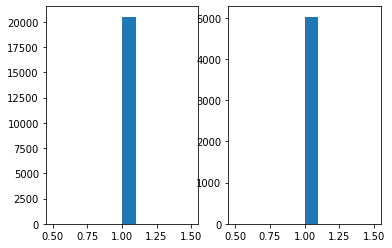

DoS attacks-GoldenEye


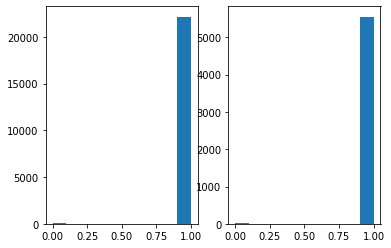

DoS attacks-Slowloris


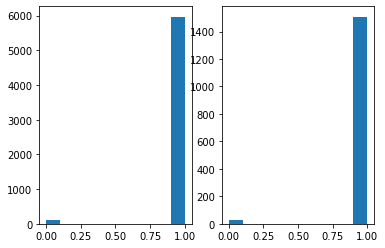

DoS attacks-SlowHTTPTest


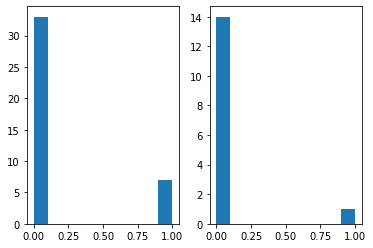

DDoS attacks-LOIC-HTTP


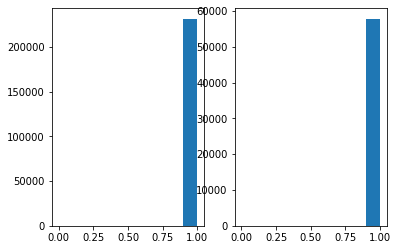

DDOS attack-HOIC


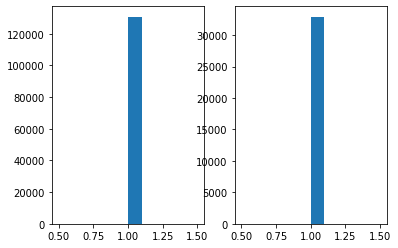

Bot


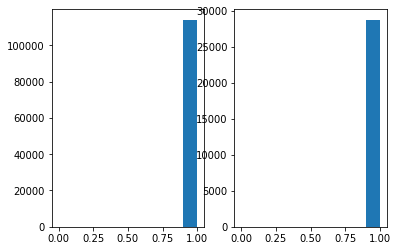

Infilteration


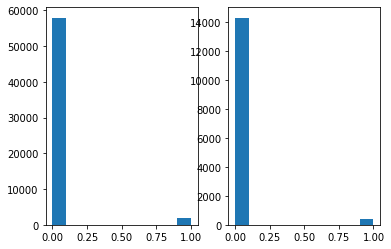

FTP-BruteForce


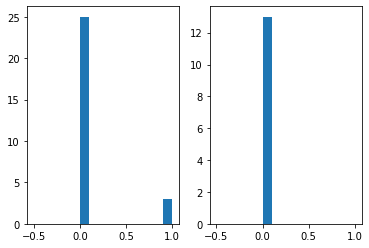

SSH-Bruteforce


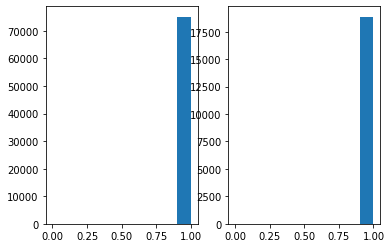

In [14]:
import matplotlib.pyplot as plt
for idx in range(len(lab_name_tot)+1):
    print((['Benign']+lab_name_tot)[idx])
    fig, ax = plt.subplots(1,2,sharex=True)
    ax[0].hist((preds['trbn'][idx]>0.5).numpy().astype(int).flatten())
    ax[1].hist((preds['tebn'][idx]>0.5).numpy().astype(int).flatten())
    plt.show()

In [15]:
lab_name

['Web_Attack', 'DoS_attacks', 'DDoS_attacks', 'Bot', 'PortScan', 'Bruteforce']

prediction results for  Benign
[0 1 2 3 4 5] [0 1 2 3 4 5]


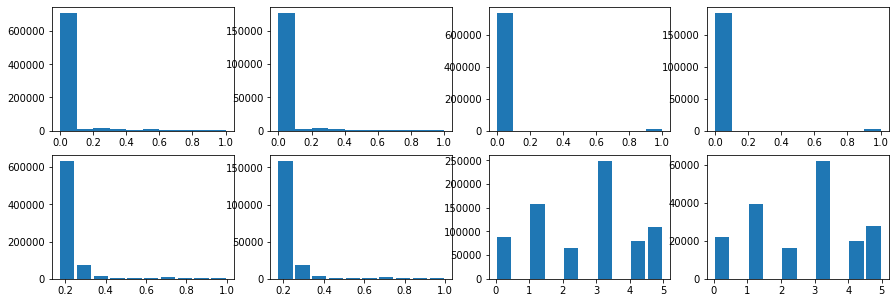

prediction results for  Web Attack  Brute Force
[0 1 4 5] [0 1 5]


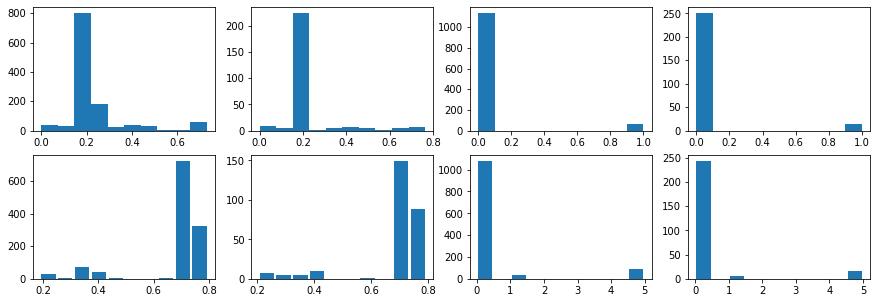

prediction results for  Web Attack  XSS
[0 1 4 5] [0 1 5]


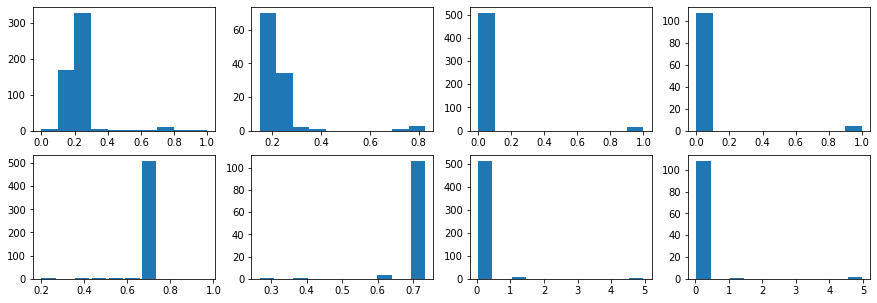

prediction results for  Web Attack  Sql Injection
[1 5] [1 5]


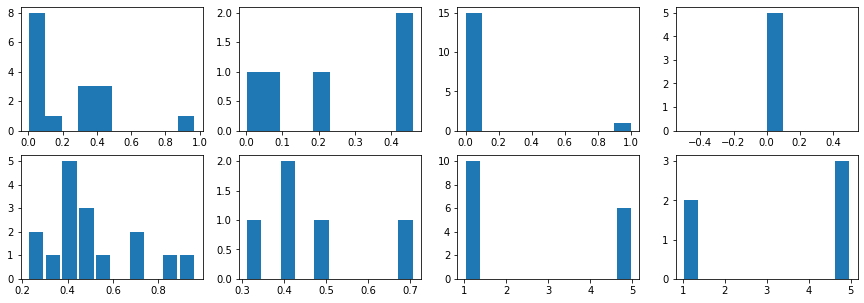

prediction results for  DoS Hulk
[0 1 2 3] [0 1 2]


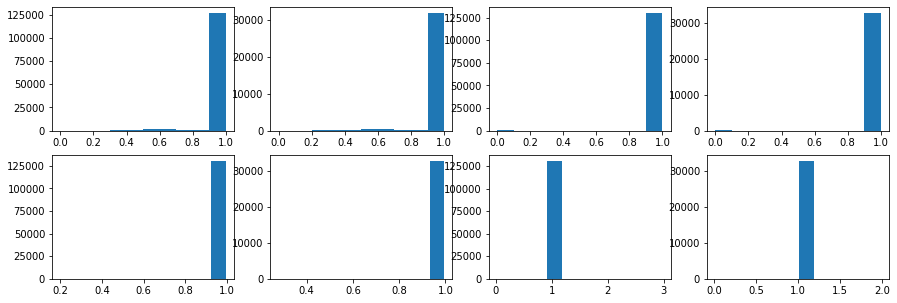

prediction results for  DoS GoldenEye
[1] [1]


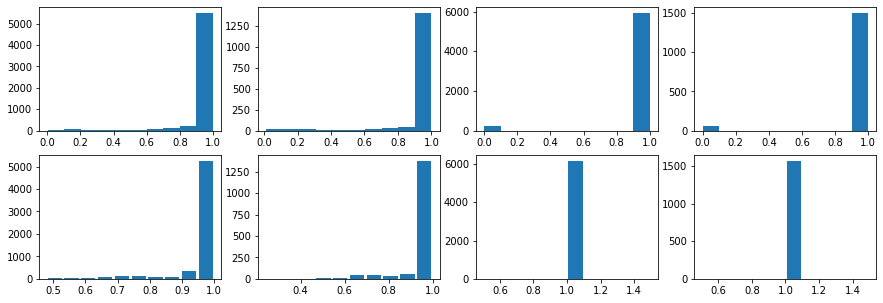

prediction results for  DoS slowloris
[0 1 3 4 5] [0 1 2 5]


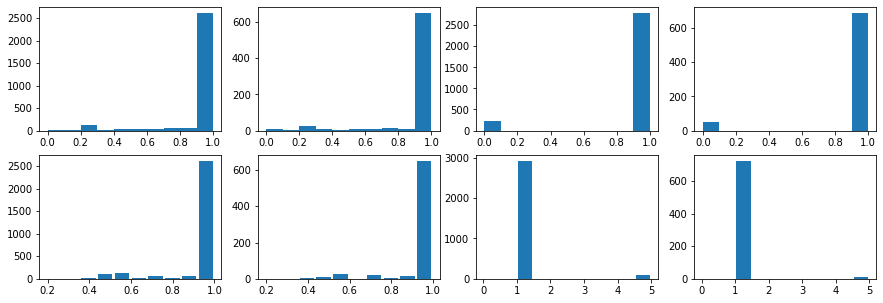

prediction results for  DoS Slowhttptest
[0 1 5] [1]


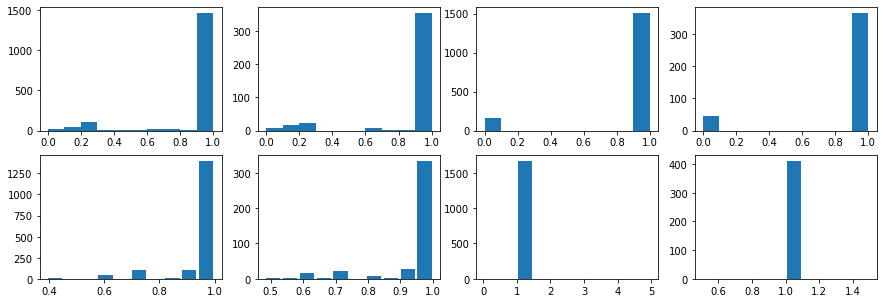

prediction results for  DDoS
[1 2 3] [1 2 3]


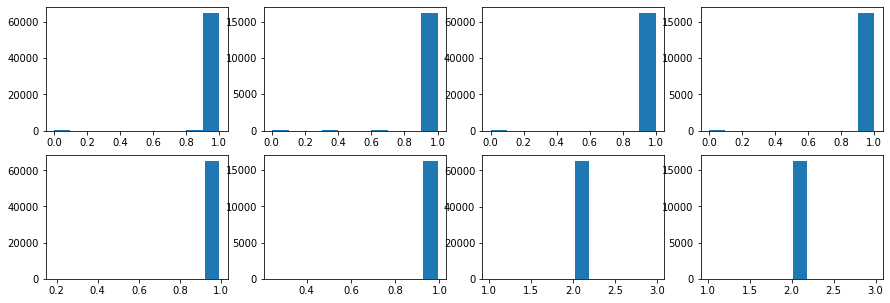

prediction results for  Bot
[2 3] [2 3]


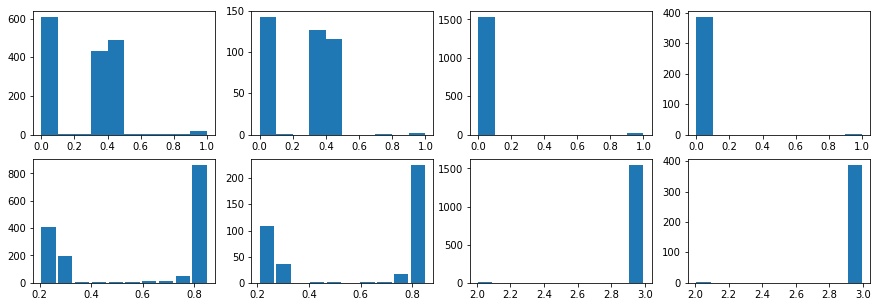

prediction results for  PortScan
[0 1 2 4 5] [0 1 4 5]


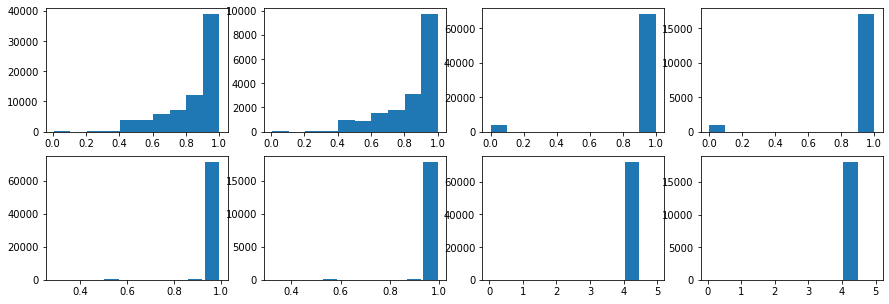

prediction results for  FTP-Patator
[0 1 4 5] [1 4 5]


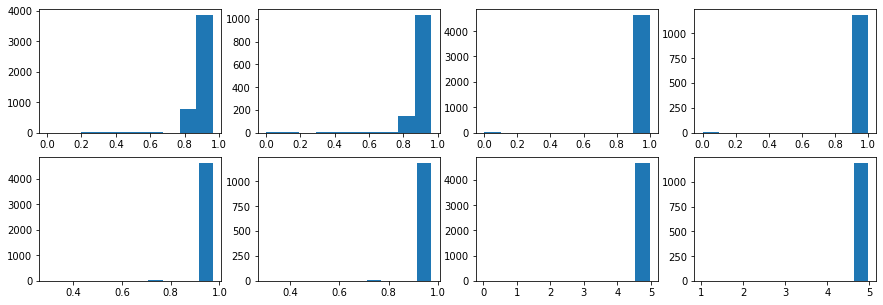

prediction results for  SSH-Patator
[1 4 5] [1 3 4 5]


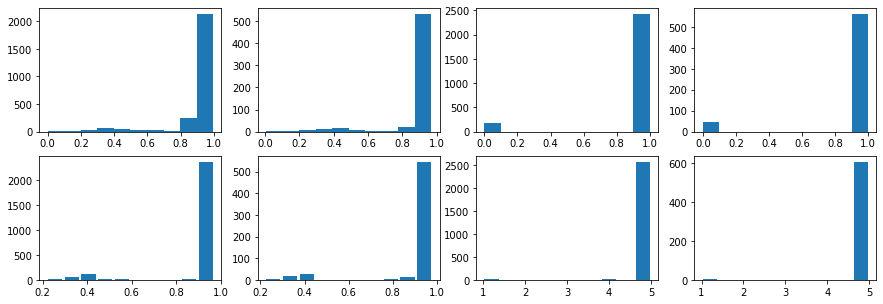

prediction results for  Heartbleed
[3] [3]


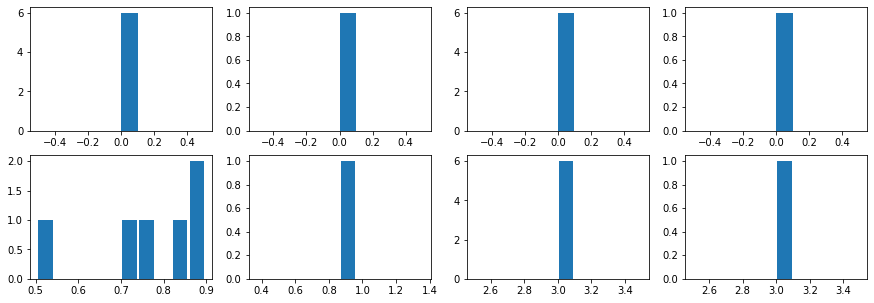

prediction results for  Infiltration
[0 1 2 3 5] [2 3]


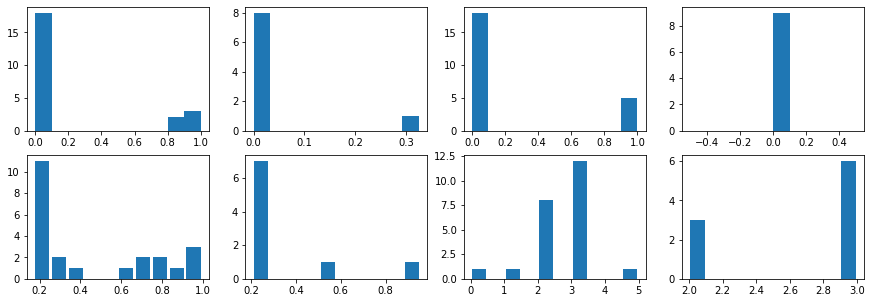

IndexError: list index out of range

In [24]:
import matplotlib.pyplot as plt
for idx in range(len(lab_name_tot)+1):
    print('prediction results for ',(lab_name_tot)[idx])
    print(np.unique(torch.max(preds['trm'][idx],dim=1)[1].numpy()),np.unique(torch.max(preds['tem'][idx],dim=1)[1].numpy()))
    fig, ax = plt.subplots(2,4, figsize=(15,5))
    ax[0,0].hist((preds['trbn'][idx]).numpy().flatten())
    ax[0,1].hist((preds['tebn'][idx]).numpy().flatten())
    ax[0,2].hist((preds['trbn'][idx]>0.5).numpy().astype(int).flatten())
    ax[0,3].hist((preds['tebn'][idx]>0.5).numpy().astype(int).flatten())
    ax[1,0].hist(torch.max(preds['trm'][idx],dim=1)[0].numpy(),rwidth=0.85)
    ax[1,1].hist(torch.max(preds['tem'][idx],dim=1)[0].numpy(),rwidth=0.85)
    ax[1,2].hist(torch.max(preds['trm'][idx],dim=1)[1].numpy(),rwidth=0.85)
    ax[1,3].hist(torch.max(preds['tem'][idx],dim=1)[1].numpy(),rwidth=0.85)

    plt.show()

In [17]:
print((preds['tebn'][idx]>0.5).numpy().astype(int).flatten())
torch.max(preds['tem'][idx],dim=1)

[1 1 1 ... 1 1 1]


torch.return_types.max(
values=tensor([0.9917, 0.9911, 0.9911,  ..., 0.9929, 0.9911, 0.9916]),
indices=tensor([5, 5, 5,  ..., 5, 5, 5]))